![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
min_gain=0.001

In [7]:
# Definición de la función que calcula el MSE
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

In [8]:
def mse_reduction(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_reduction_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
      
    return mse_reduction_

In [9]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, reduction
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            reduction = mse_reduction(X.iloc[:, j], y, split)
                        
            if reduction > best_split[2]:
                best_split = [j, split, reduction]
    
    return best_split

In [10]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [11]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [12]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [13]:
y_pred=tree_predict(X_test, tree)
y_pred

array([13339.12290503,  6702.29545455, 15976.18762089, ...,
       18275.50387597, 12674.15      , 10678.68181818])

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
maetree = mean_absolute_error(y_test, y_pred)
rmsetree = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE Tree: ", maetree)
print("RMSE: ", rmsetree)

MAE Tree:  1223.6868231205608
RMSE:  1643.307841242522


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [15]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [16]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i in range(n_B):
    X_b = X_train.iloc[samples[i],]
    y_b = y_train.iloc[samples[i],]
    treereg=DecisionTreeRegressor().fit(X_b, y_b)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13490.0,11788.0,13649.0,13993.0,13993.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6700.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,17952.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16998.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,14800.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12995.0,12991.0,12893.0


In [17]:
# Predicciones promedio para cada obserbación del set de test
y_pred=y_pred.mean(axis=1)
y_pred

257343    13751.8
326011     6214.4
242354    16694.3
266376    21079.2
396954    16472.8
           ...   
144298    14595.3
364521    16109.0
120072    21076.5
99878     12782.4
387162    12025.5
Length: 3464, dtype: float64

In [18]:
# Error al promediar las predicciones de todos los árboles
maebagm = mean_absolute_error(y_test, y_pred)
rmsebagm = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE BagM: ", maebagm)
print("RMSE BagM: ", rmsebagm)

MAE BagM:  1342.830941108545
RMSE BagM:  1798.550039789772


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingRegressor
import math
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features=int(math.log(X.shape[1])),
                          bootstrap=True, oob_score=True, random_state=1)

In [20]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
maebagl = mean_absolute_error(y_test, y_pred)
rmsebagl = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE BagL: ", maebagl)
print("RMSE BagL: ", rmsebagl)

MAE BagL:  2074.9760882251453
RMSE BagL:  2671.0127988157697


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [21]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)

maerf = mean_absolute_error(y_test, y_pred)
rmserf = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE RF: ", maerf)
print("RMSE RF: ", rmserf)

MAE RF:  1309.794721197602
RMSE RF:  1758.1086780656174


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### max_depth

In [22]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 20 , 2)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
rmse = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

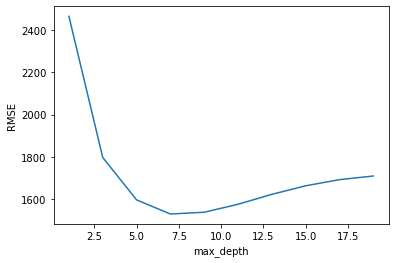

In [23]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
import matplotlib.pyplot as plt
plt.plot(depth_range, rmse)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

### max_features

In [24]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for features in feature_range:
    clf = RandomForestRegressor(max_features=features, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

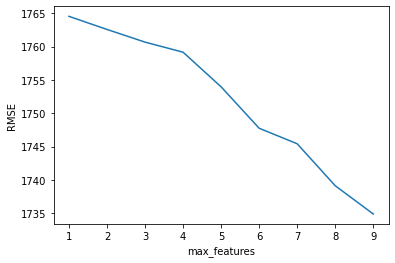

In [25]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse)
plt.xlabel('max_features')
plt.ylabel('RMSE')

### n_estimators

In [26]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 210, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
rmse = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

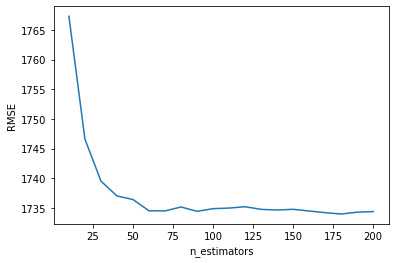

In [27]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [28]:
reg=RandomForestRegressor(max_depth=7,max_features=9,n_estimators=50)
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)

maerfc = mean_absolute_error(y_test, y_pred)
rmserfc = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE RFC: ", maerfc)
print("RMSE RFC: ", rmserfc)

MAE RFC:  1155.5078058908207
RMSE RFC:  1566.9360358151157


### GridSearch

from sklearn.model_selection import GridSearchCV

reg=RandomForestRegressor()

# Parámetros
param_grid = {'max_depth': [4, 8],
              'max_features': [3, 6],
              'n_estimators': [300, 600]}

# Búsqueda mejor modelo
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
# Mejores parámetros
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Estimar el modelo
best_regressor = grid_search.best_estimator_

# Predicción
y_pred = best_regressor.predict(X_test)

maerfc = mean_absolute_error(y_test, y_pred)
rmserfc = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE RFC: ", maerfc)
print("RMSE RFC: ", rmserfc)

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [29]:
# Celda 6
from xgboost import XGBRegressor
reg = XGBRegressor()
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
maexgb = mean_absolute_error(y_test, y_pred)
rmsexgb = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE XGB: ", maexgb)
print("RMSE XGB: ", rmsexgb)

MAE XGB:  1185.2272991506386
RMSE XGB:  1605.2355199928948


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### learning rate

In [30]:
# Celda 7
# Creación de lista de valores para iterar sobre diferentes valores de max_features
rate_range = np.arange (0.01, 0.2, 0.01)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for rate in rate_range:
    clf = XGBRegressor(learning_rate=rate, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

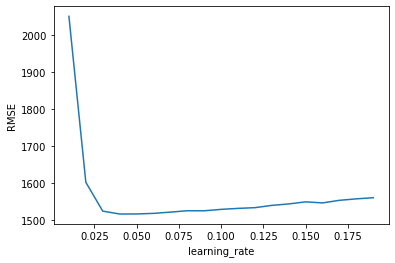

In [31]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(rate_range, rmse)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')

### gamma

In [32]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
gamma_range = np.arange (0, 30000, 1000)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for gamma in gamma_range:
    clf = XGBRegressor(gamma=gamma, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

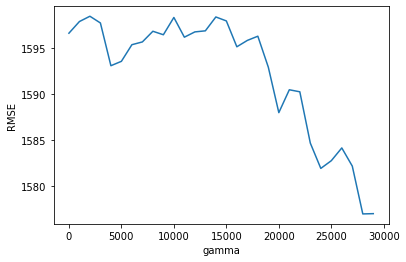

In [33]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, rmse)
plt.xlabel('gamma')
plt.ylabel('RMSE')

### colsample_bytree

In [34]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
col_range = np.arange (0, 1, 0.01)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for col in col_range:
    clf = XGBRegressor(colsample_bytree=col, random_state=1, n_jobs=-1)
    rmse.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

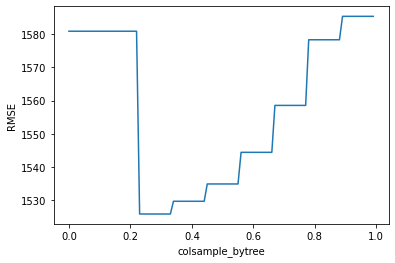

In [35]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(col_range, rmse)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

In [36]:
from xgboost import XGBRegressor
reg = XGBRegressor(learning_rate=0.025,gamma=30000,colsample_bytree=0.2)
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
maexgbc = mean_absolute_error(y_test, y_pred)
rmsexgbc = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE XGBC: ", maexgbc)
print("RMSE XGBC: ", rmsexgbc)

MAE XGBC:  1882.3759869934504
RMSE XGBC:  2443.6529999919135


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [37]:
# Celda 8
print("MAE RF: ", maerf)
print("RMSE RF: ", rmserf)
print("MAE RFC: ", maerfc)
print("RMSE RFC: ", rmserfc)
print("MAE XGB: ", maexgb)
print("RMSE XGB: ", rmsexgb)
print("MAE XGBC: ", maexgbc)
print("RMSE XGBC: ", rmsexgbc)

MAE RF:  1309.794721197602
RMSE RF:  1758.1086780656174
MAE RFC:  1155.5078058908207
RMSE RFC:  1566.9360358151157
MAE XGB:  1185.2272991506386
RMSE XGB:  1605.2355199928948
MAE XGBC:  1882.3759869934504
RMSE XGBC:  2443.6529999919135
